In [102]:
%env CUDA_VISIBLE_DEVICES=0
import torch
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import math

env: CUDA_VISIBLE_DEVICES=0


# Set up Cuda

In [103]:
CUDA = torch.cuda.is_available()
#CUDA = False
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")

True


# Define functions to generate and check learning parameters

In [104]:
#Given desired output length, filter length, latent input length, and stride - check if the params are valid
def check_params(out_len, filt_len, in_len, stride):
    n_true = (in_len - 1)*stride + filt_len
    f_true = out_len - (in_len - 1)*stride
    k_true = (out_len - filt_len)/stride + 1
    s_true = (out_len - filt_len)/(in_len - 1)
    
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return False
    
    if(out_len != n_true or filt_len != f_true or in_len != k_true or not k_true.is_integer() or not s_true.is_integer()):
        return False
    
    return True

#get stride given three other parameters; returns -1 if input is an invalid combo
def get_s(out_len, filt_len, in_len):
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(in_len, int))):
        return -1
    
    stride = (out_len - filt_len)/(in_len - 1)
    
    if(not stride.is_integer()):
        return -1
    
    return int(stride)

#get latent input length given three other parameters; returns -1 if input is an invalid combo
def get_k(out_len, filt_len, stride):
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(stride, int))):
        return -1
    
    in_len = (out_len - filt_len)/stride + 1
    
    if(not in_len.is_integer()):
        return -1
    
    return int(in_len)

#get filter length given three other parameters; returns -1 if input is an invalid combo
def get_f(out_len, in_len, stride):
    if(not (isinstance(out_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return -1
    
    filt_len = out_len - (in_len - 1)*stride
    
    return filt_len

#get output length given three other parameters; returns -1 if input is an invalid combo
def get_n(filt_len, in_len, stride):
    if(not (isinstance(filt_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return -1
    
    out_len = (in_len - 1)*stride + filt_len
    
    return out_len

# Define parameters and check the generator functions

In [113]:
#define output len, filter len, input len, and stride
n = 64
f = 16 
k = 4
s = 16

#check if the params are valid - should return true
print(check_params(n,f,k,s))

print(get_n(f,k,s) == n)
print(get_f(n,k,s) == f)
print(get_k(n,f,s) == k)
print(get_s(n,f,k) == s)

True
True
True
True
True


# Define functions to generate the weight vector and Data matrix

In [106]:
#generate a weight vector made by concatenating nc vectors of length f vertically, initiliazed with N(0,1) weights
def gen_weights(f, nc, cuda):
    weights = torch.zeros((f*nc))
    weights.data.normal_(0, 1)
    
    if(cuda):
        weights = weights.cuda()
    
    return weights

#generate a single strided block of latent input - contains k N(0,1) entries with (s-1) zeros between each entry
def gen_z_block(k, s, cuda):
    z = torch.zeros(k)
    z.data.normal_(0, 1)
    
    if(cuda):
        z = z.cuda()

    z_strided = torch.zeros((k - 1)*s + 1)

    if(cuda):
        z_strided = z_strided.cuda()

    inds = [i*s for i in range(k)]

    z_strided[inds] = z
    
    return z_strided

#generate a (n,f) latent input matrix for one channel - contains a strided z block shifted down one row in each column 
def gen_z_mat(n, f, k, s, cuda):
    z_block = gen_z_block(k, s, cuda)
    block_len = list(z_block.shape)[0]
    
    z_mat = torch.zeros((n, f))
    
    if(cuda):
        z_mat = z_mat.cuda()
    
    for i in range(f):
        z_mat[i:block_len + i, i] = z_block
        
    return z_mat

#generate a Z matrix used as Data in linear regression, made by concatenating nc latent input matrices horizontally 
def gen_z_data(n, f, k, s, nc, cuda):
    z_latent = torch.zeros((n, f*nc))
    
    if(cuda):
        z_latent = z_latent.cuda()
    
    for i in range(nc):
        z_latent[:, i*f:i*f+f] = gen_z_mat(n, f, k, s, cuda)
    
    return z_latent

# Check the generator functions

In [114]:
#set the number of channels
nc = 10

#generate the weights and data matrix (Z) to be used in linear regression
weights = gen_weights(f, nc, CUDA)
Z = gen_z_data(n, f, k, s, nc, CUDA)

print(weights)
print(Z)

tensor([-1.0606,  0.8487, -0.5291,  0.3514, -0.6131, -0.6443, -1.6613, -1.2940,
         1.0743,  0.1112,  0.6784,  0.9076, -0.7647, -0.6010,  0.6893, -0.5175,
         0.4135, -0.1370, -0.9813, -1.7621, -0.6678,  0.0722, -0.5836,  0.9547,
         0.0043,  0.9957,  0.4582,  1.2095, -1.0377,  0.1580,  0.1012,  0.6791,
        -1.8567, -0.9362, -0.5805,  0.8893, -0.6429,  0.5233,  1.9785,  0.6713,
         0.9757,  1.1859,  0.2696,  1.5320,  0.8294,  1.7260, -1.4400,  0.5657,
        -1.8692,  0.2798,  0.8960,  0.8078, -2.1038, -2.0056, -1.0441,  0.7216,
        -2.3578,  0.4700,  0.1159, -1.0984, -0.3233,  0.7112,  1.0099,  0.2984,
        -0.4572, -0.0944,  0.2784,  0.3725, -1.0160,  1.2638,  1.2623, -0.8609,
         0.0240, -0.1969, -0.2635, -0.9845, -0.0406,  0.6944, -1.7225, -1.8552,
        -1.1180,  0.4245, -0.3579,  0.5210, -0.0419, -1.2357, -0.5031, -0.0880,
         0.7638,  1.1744,  0.1812, -1.9636, -1.1224, -0.0105, -0.5593, -1.3795,
         1.3918,  0.6466, -1.5130,  1.78

# Define gradient function

In [108]:
def get_gradient(y, Z, w):
    return torch.matmul(Z.t(), y) - torch.matmul(torch.matmul(Z.t(), Z), w)

# Define Gradient Descent

In [109]:
#given target signal y, data Z, weights w, stepsize, and number of iterations, perform gradient descent for linear regression on w 
#optionally can choose to log the MSE of each iterative solution
def gradient_descent(y, Z, w, stepsize, num_iter, log = False):
    w_t = w
    
    if(log):
        mse = torch.nn.MSELoss().type(dtype)
        mse_log = torch.zeros((num_iter))
    
    for i in range(num_iter):
        w_t = w_t + stepsize*get_gradient(y, Z, w_t)
        
        if(log):
            mse_log[i] = mse(y, torch.matmul(Z, w_t))
    
    if(log):
        return (w_t, mse_log)
    
    return w_t

# Create Target

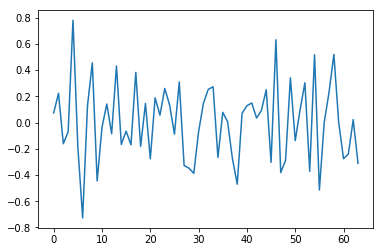

In [110]:
X_OUTPUT = np.arange(n)

#y0 = np.sin(2 * np.pi *X_OUTPUT / n) + 0.25 * np.random.randn(n)
y0 = 0.25 * np.random.randn(n)
y = torch.tensor(y0).type(dtype)

if(CUDA):
    y = y.cuda()

plt.figure()
plt.plot(X_OUTPUT, y0)
plt.show()

# Perform Linear Regression

In [111]:
stepsize = 1e-3
NUM_ITER = 100

weights, log = gradient_descent(y, Z, weights, stepsize, NUM_ITER, True)

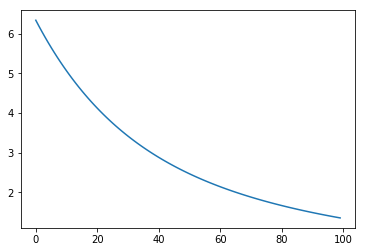

In [112]:
plt.figure()
plt.plot(range(NUM_ITER), log.cpu().numpy())
plt.show()